<a href="https://colab.research.google.com/github/johanamirandag/Fisica-computacional/blob/main/Evaluacion1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importamos las bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## **Paso 1** Construcción de una Serie de Tiempo. 

In [ ]:
# Tomar la dirección URL del archivo en formato 'raw'
url = 'https://raw.githubusercontent.com/johanamirandag/Fisica-computacional/main/Evaluacion1/Observatorio%20de%20Mauna%20Loa%2C%20Hawaii.%20.txt'

In [ ]:
# Definimos los nombres de las columnas
# El archivo tiene códigos ASCII extendido (Español), encoding='cp1251' Windows (Europa Occidental)
# El separador de datos es de uno o más espacios, sep='\s+'
# Se brincará los primeros 152 renglones y el último, afirmamos que no nay encabezado
# Se procesan los datos utilizando Python, engine='python' 
my_cols = ['site_code','Año','Mes','Dia','Hora','Minuto','Segundo','time_decimal','Concentracion CO2','value_std_dev','nvalue','Latitud','Longitud','Altitud','Elevacion','intake_height','qcflag']
df_distribucion = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=152, skipfooter=1, engine='python')

# Hacemos una copia de trabajo y preservamos el dataframe original
df_trabajo0 = df_distribucion.copy()

# Reemplazamos los textos '-999.99' por 'NaN'
str_Nulo = -999.99
df_trabajo1 = df_trabajo0.replace(to_replace=str_Nulo, value='NaN', regex=True)

# Deseamos convertir los valores de las variables ambientales a núm. flotantes 
cols_list = ['site_code','Año','Mes','Dia','Hora','Minuto','Segundo','time_decimal','Concentracion CO2','value_std_dev','nvalue','Latitud','Longitud','Altitud','Elevacion','intake_height','qcflag']
for cols in cols_list:
  df_trabajo1[cols] = pd.to_numeric(df_trabajo1[cols], errors='coerce')

# Volvemos a hacer una pausa y definimos un nuevo dataframe por si hay que regresarse.
df_trabajo2_ts = df_trabajo1.copy()

#Con estas filas cree la nueva columna fecha uniendo el año, mes y día.
df_trabajo2_ts['Fecha'] = pd.to_datetime(df_trabajo2_ts[['Año','Mes','Dia']]
                   .astype(str).apply(' '.join, 1), format='%Y %m %d')

df_trabajo2_ts['Fecha'] = (pd.to_datetime(df_trabajo2_ts['Año'].astype(str) + '-' +
                                  df_trabajo2_ts['Mes'].astype(str) + '-' +
                                  df_trabajo2_ts['Dia'].astype(str)))

#df_trabajo2 = df_trabajo2.drop(['Año','Mes','Dia','site_code','Hora','Minuto','Segundo','time_decimal','value_std_dev','nvalue','Latitud','Longitud','Altitud','Elevacion','intake_height','qcflag'], axis=1)

In [ ]:
# Definimos un nuevo DataFrame para el análisis de los datos. 
# Será nuestro nuevo punto de partida.
df_datos_ts = df_trabajo2_ts.copy()
print(df_datos_ts.head())
print(df_datos_ts.tail())

   site_code   Año  Mes  Dia  ...  Elevacion  intake_height  qcflag      Fecha
0        NaN  1973    1    1  ...     3397.0           40.0     NaN 1973-01-01
1        NaN  1973    1    2  ...     3397.0           40.0     NaN 1973-01-02
2        NaN  1973    1    3  ...     3397.0           40.0     NaN 1973-01-03
3        NaN  1973    1    4  ...     3397.0           40.0     NaN 1973-01-04
4        NaN  1973    1    5  ...     3397.0           40.0     NaN 1973-01-05

[5 rows x 18 columns]
       site_code   Año  Mes  Dia  ...  Elevacion  intake_height  qcflag      Fecha
17160        NaN  2019   12   26  ...     3397.0           40.0     NaN 2019-12-26
17161        NaN  2019   12   27  ...     3397.0           40.0     NaN 2019-12-27
17162        NaN  2019   12   28  ...     3397.0           40.0     NaN 2019-12-28
17163        NaN  2019   12   29  ...     3397.0           40.0     NaN 2019-12-29
17164        NaN  2019   12   30  ...     3397.0           40.0     NaN 2019-12-30

[5 r

Creamos un **Serie de Tiempo** desde el inicio de 1980 hasta fin de 2019, fijando a la variable 'Fecha' como nuevo índice del DataFrame.

In [ ]:
df_datos_ts = df_datos_ts.copy()
df_datos_ts = df_datos_ts.set_index('Fecha')
# Vamos a utilizar los últimos de datos, que corresponden al periodo 1980-2019
df_80_ts = df_datos_ts[(df_datos_ts['Año'] >= 1980) & (df_datos_ts['Año'] < 2020)]
df_80_ts.head()

,site_code,Año,Mes,Dia,Hora,Minuto,Segundo,time_decimal,Concentracion CO2,value_std_dev,nvalue,Latitud,Longitud,Altitud,Elevacion,intake_height,qcflag
Fecha,,,,,,,,,,,,,,,,,
1980-01-01,NaN,1980,1,1,0,0,0,1980.000000,337.85,0.12,15,19.536,-155.576,3437.0,3397.0,40.0,NaN
1980-01-02,NaN,1980,1,2,0,0,0,1980.002732,337.32,0.35,11,19.536,-155.576,3437.0,3397.0,40.0,NaN
1980-01-03,NaN,1980,1,3,0,0,0,1980.005464,337.75,0.05,15,19.536,-155.576,3437.0,3397.0,40.0,NaN
1980-01-04,NaN,1980,1,4,0,0,0,1980.008197,337.70,0.04,15,19.536,-155.576,3437.0,3397.0,40.0,NaN
1980-01-05,NaN,1980,1,5,0,0,0,1980.010929,337.65,0.08,15,19.536,-155.576,3437.0,3397.0,40.0,NaN


La serie de tiempo de concentraciones de CO2, sólo deberá tener la Fecha como índice y la columna de CO2.  

In [ ]:
df_80co2_ts = df_80_ts.drop(['site_code','Año','Mes','Dia','Hora','Minuto','Segundo','time_decimal','value_std_dev','nvalue','Latitud','Longitud','Altitud','Elevacion','intake_height','qcflag'], axis=1)
df_80co2_ts.head(10)

,Concentracion CO2
Fecha,
1980-01-01,337.85
1980-01-02,337.32
1980-01-03,337.75
1980-01-04,337.70
1980-01-05,337.65
1980-01-06,337.25
1980-01-07,337.86
1980-01-08,337.31
1980-01-09,NaN


Usamos  ts_test.ffill(axis = 0, inplace=True), para rellenar hacia enfrente los valores vacíos en base al último valor anterior disponible.  

In [ ]:
df_80co2_ts.ffill(axis = 0, inplace=True)

## **Paso 2** Análisis de la Serie de Tiempo.

## Define una función para probar estacionaridad utilizando la Prueba Avanzada de Dickey-Fuller: test_stationarity(df_ts)

In [ ]:
# Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts):
    
    #Determinar la Estadística
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desvación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

## Prueba la estacionaridad de tu serie de tiempo 'ts_test' en base al valor p.

In [ ]:
# Creamos la primer serie de Tiempo para analizar, 
# haciendo una copia de la epoca de 1980 a 2019
# o el periodo que se desee. Podemos regresar a esta punto las veces que se requiera definir

# Fechas de inicio y fin, para filtrar la información
start, end = '1980-01', '2019-12'
ts_80 = df_80co2_ts.loc[start:end].copy()
ts_80.head()

,Concentracion CO2
Fecha,
1980-01-01,337.85
1980-01-02,337.32
1980-01-03,337.75
1980-01-04,337.70
1980-01-05,337.65


In [ ]:
# Vemos su encabezado
ts_80['Concentracion CO2'].head()

Fecha
1980-01-01    337.85
1980-01-02    337.32
1980-01-03    337.75
1980-01-04    337.70
1980-01-05    337.65
Name: Concentracion CO2, dtype: float64

In [ ]:
# Definimos la Serie de Tiempo con Concentracion de CO2 que vamos a estudiar, le damos un nombre genérico

ts_test = ts_80['Concentracion CO2'].copy()

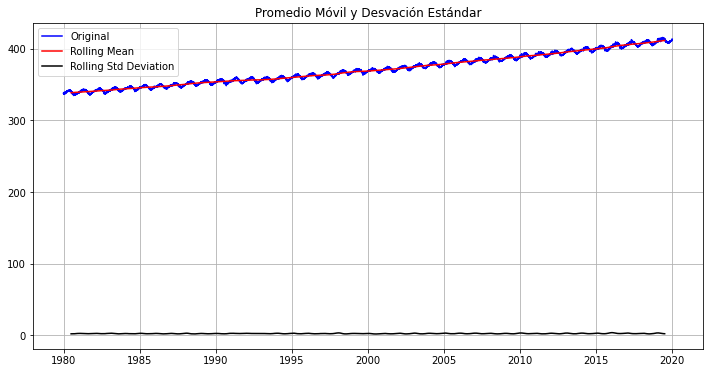

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                    -1.023213
p-value                            0.744704
#Lags Used                        42.000000
Number of Observations Used    14566.000000
Critical Value (1%)               -3.430799
Critical Value (5%)               -2.861738
Critical Value (10%)              -2.566876
dtype: float64


In [ ]:
# Realizamos la Prueba de Estacionalidad de la Concentración de CO2
test_stationarity(ts_test)

Notamos que el valor p es p > 0.05 (0.744704), lo que indica que no es estacionaria, por lo que es mejor usar la escala logaritmica.

## Cambia de escala a Log(CO2), y gráfica la nueva función. 

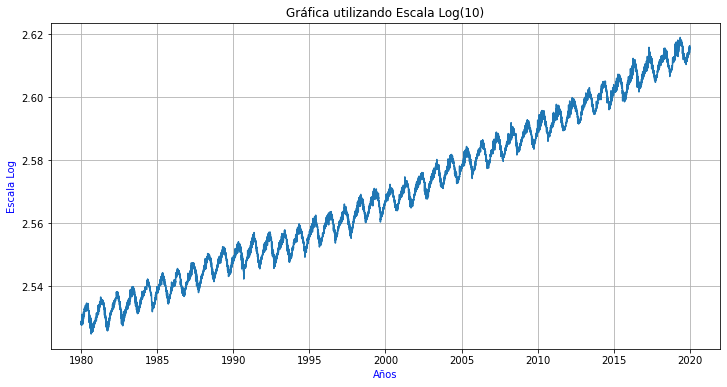

In [ ]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_log = np.log10(ts_test)
plt.plot(ts_test_log)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

##  Haz una descomposición estacional de la serie 'ts_test_log', usando interpolación, y promedio móvil de 365 días. Produce las gráficas de las series que la componen. Comenta la serie de tendencia (aumento de CO2), estacionalidad (dependencia de las estaciones del año) y residuo (el resto).  

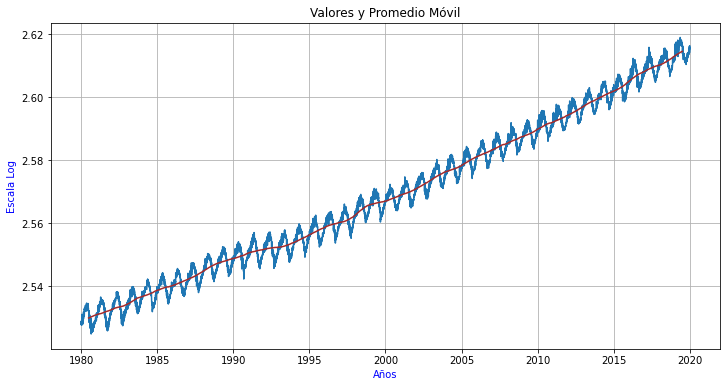

In [ ]:
moving_avg = ts_test_log.rolling(365, center=True).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

In [ ]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

Fecha
1980-01-01   NaN
1980-01-02   NaN
1980-01-03   NaN
1980-01-04   NaN
1980-01-05   NaN
Name: Concentracion CO2, dtype: float64

In [ ]:
ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()

Fecha
1980-07-01    0.002344
1980-07-02    0.002353
1980-07-03    0.002196
1980-07-04    0.002207
1980-07-05    0.002192
Name: Concentracion CO2, dtype: float64

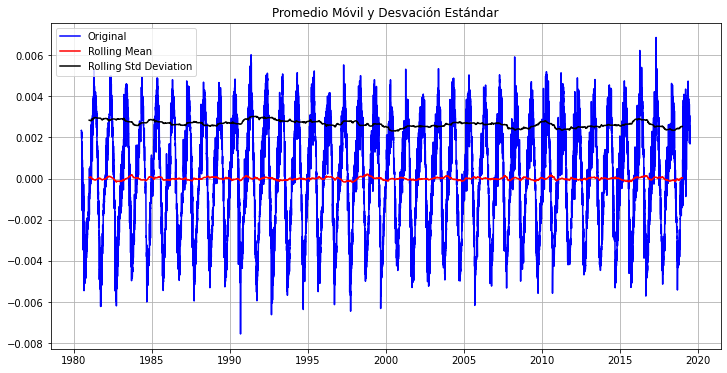

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.400738e+01
p-value                        3.766921e-26
#Lags Used                     4.200000e+01
Number of Observations Used    1.420200e+04
Critical Value (1%)           -3.430811e+00
Critical Value (5%)           -2.861744e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [ ]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test_log_moving_ave_diff)

El p valor es p < 0.05, lo que quiere decir que la serie de tiempo es estacionaria. Después haremos una descomposición estacional de series de tiempo.

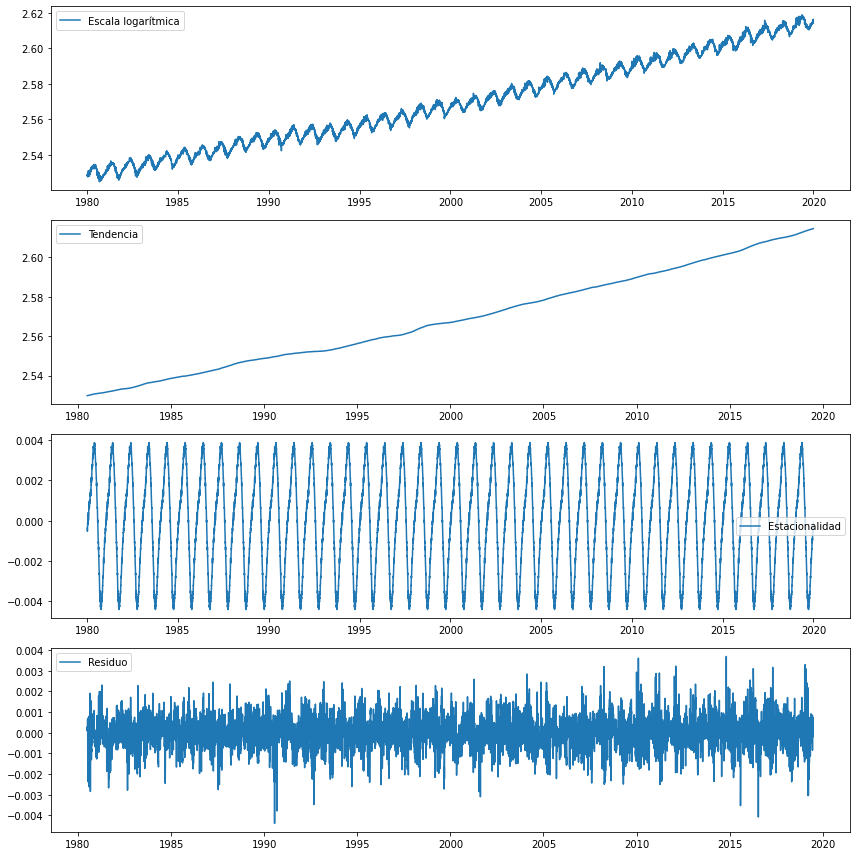

In [ ]:
# Método de descomposición usando statsmodels.tsa

descomposicion_estacional = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# 3 componentes: tendencia, estacionalidad, residuo

Tendencia = descomposicion_estacional.trend
Estacionalidad = descomposicion_estacional.seasonal
Residuo = descomposicion_estacional.resid

# Gráficas de componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Escala logarítmica')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(Tendencia, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(Estacionalidad, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(Residuo, label='Residuo')
plt.legend(loc='best')

# Esto es para disminuir espacio entre gráficos
plt.tight_layout();

Se puede observar que la tendencia (concentración de CO2) va en aumento.

Observando la estacionalidad podemos ver que la acumulación de CO2 depende de la estación del año.

El residuo muestra valores extraños.

## Prueba la estacionaridad de la serie residuo

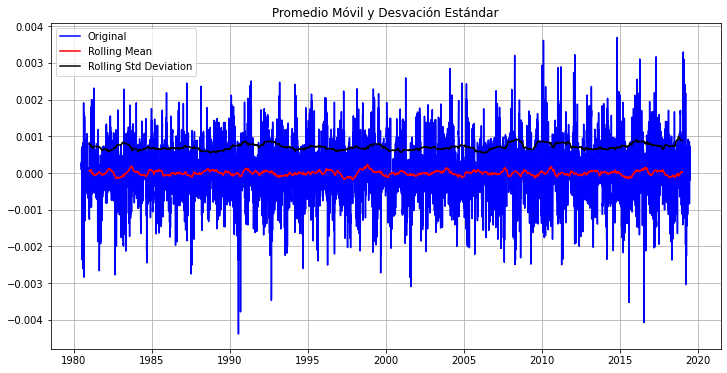

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -19.161429
p-value                            0.000000
#Lags Used                        21.000000
Number of Observations Used    14223.000000
Critical Value (1%)               -3.430810
Critical Value (5%)               -2.861743
Critical Value (10%)              -2.566878
dtype: float64


In [ ]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_log_decompose = Residuo 
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)

Esta serie es estacionaria porque la prueba da un valor de p < 0.05 (0.000000). Podemos afirmar que es una serie de tiempo estacionaria con un 100% de confianza.


##   Luego calcula un promedio móvil centrado sobre 'ts_test_log' usando un periodo de 365 días y contrastarlo en una gráfica con la serie de Log CO2.

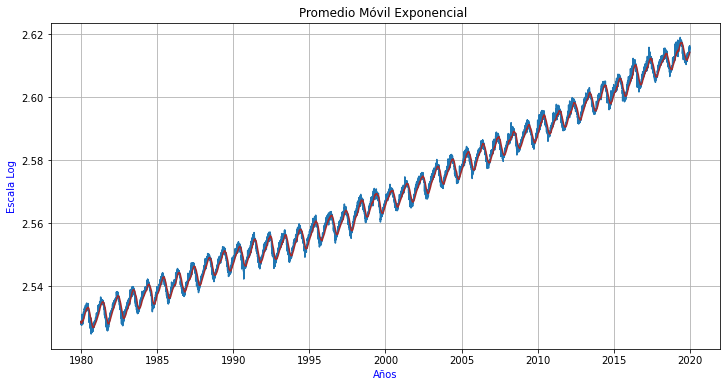

In [ ]:
# Repetimos el cálculo usando promedios móviles exponenciales, 
# el parámetro 'halflife' representa el número de días que tienen cierta influencia
# en el promedio, pero su influencia decae exponencialmente.  

EWM_avg = ts_test_log.ewm(halflife=20).mean()
plt.plot(ts_test_log)
plt.plot(EWM_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show();

##   Define un nuevo dataframe con la diferencia entre la serie logaritmo original y el promedio móvil, y prueba después su estacionaridad.

In [ ]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

Fecha
1980-01-01   NaN
1980-01-02   NaN
1980-01-03   NaN
1980-01-04   NaN
1980-01-05   NaN
Name: Concentracion CO2, dtype: float64

In [ ]:
ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()

Fecha
1980-07-01    0.002344
1980-07-02    0.002353
1980-07-03    0.002196
1980-07-04    0.002207
1980-07-05    0.002192
Name: Concentracion CO2, dtype: float64

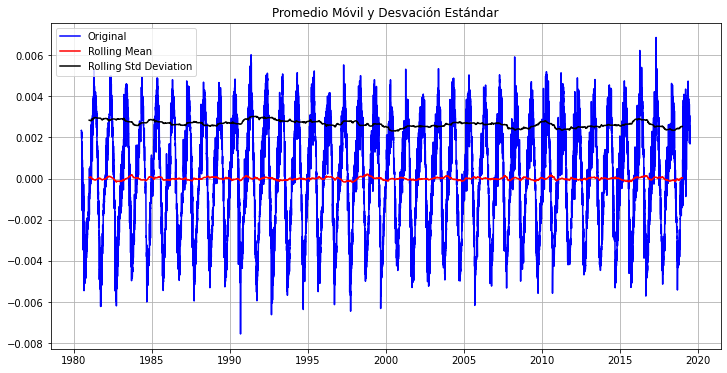

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.400738e+01
p-value                        3.766921e-26
#Lags Used                     4.200000e+01
Number of Observations Used    1.420200e+04
Critical Value (1%)           -3.430811e+00
Critical Value (5%)           -2.861744e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [ ]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test_log_moving_ave_diff)

##   Adicionalmente, prueba construir una serie estacionaria usando la función de diferenciación shift con un periodo de 7 días, que utiliza menos puntos que el promedio móvil.  

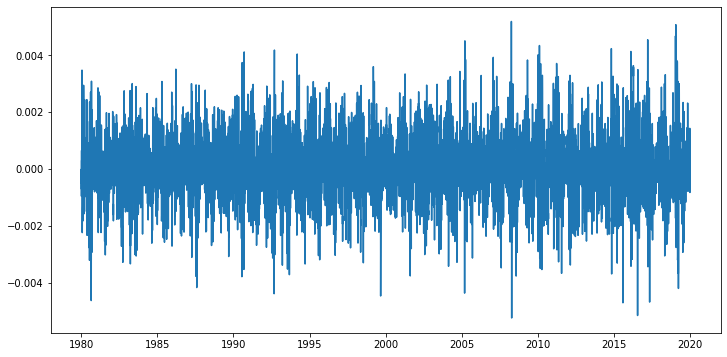

In [ ]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
plt.plot(ts_test_log_diff);

##   Prueba la estacionaridad de esa última serie de tiempo 'ts_test_log_diff'.

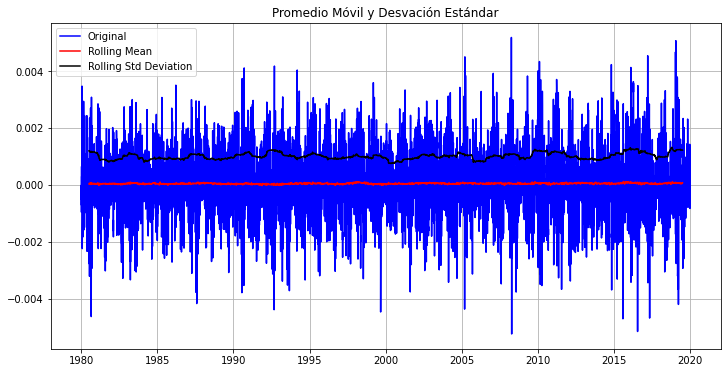

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.002419e+01
p-value                        1.648540e-17
#Lags Used                     4.200000e+01
Number of Observations Used    1.455900e+04
Critical Value (1%)           -3.430799e+00
Critical Value (5%)           -2.861739e+00
Critical Value (10%)          -2.566876e+00
dtype: float64


In [ ]:
# Probamos la estacionaridad
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)

In [ ]:
# Número de datos utilizados
len(ts_test_log_diff)

14602

##   Construye un modelo ARIMA de la serie 'ts_test_log_diff', calculando los parámetros p, q y utiliza d=1 (ya que hemos ya derivado una vez)  

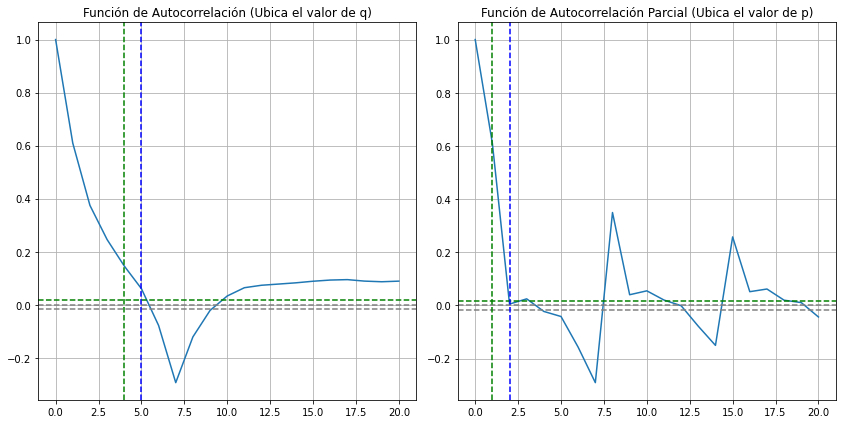

In [ ]:
# Aplicamos ARIMA

lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.axvline(x=5, linestyle='--', color='blue')
plt.grid()
plt.title('Función de Autocorrelación (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=1, linestyle='--', color='green')
plt.axvline(x=2, linestyle='--', color='blue')
plt.grid()
plt.title('Función de Autocorrelación Parcial (Ubica el valor de p)')

plt.tight_layout()

-   En la primera gráfica, vemos dos líneas, una verde y una azul. La línea verde es igual a 4 y la línea azul es igual a 5. Consideramos q = 4 ya que el valor entero más cercano es 4.
-   En la segunda gráfica, la misma situación con las líneas. Aquí, consideramos p = 2 ya que el valor entero más cercano es 2.

###     Para seleccionar el mejor modelo, calcula el Criterio de Información de Akaike (AIC) de los modelos: AR(p), MA(q), y ARIMA (p,d,q). 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                              ARIMA Model Results                              
Dep. Variable:     D.Concentracion CO2   No. Observations:                14608
Model:                  ARIMA(2, 1, 0)   Log Likelihood               87403.569
Method:                        css-mle   S.D. of innovations              0.001
Date:                 Thu, 25 Feb 2021   AIC                        -174799.137
Time:                         01:09:52   BIC                        -174768.780
Sample:                     01-02-1980   HQIC                       -174789.052
                          - 12-30-2019                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      5.989e-06   3.53e-06      1.699      0.089   -9.22e-07    1.29e-05
ar.L1.D.Concentracion CO2    -0.2438      0.008    -29.993      0.000      -0.

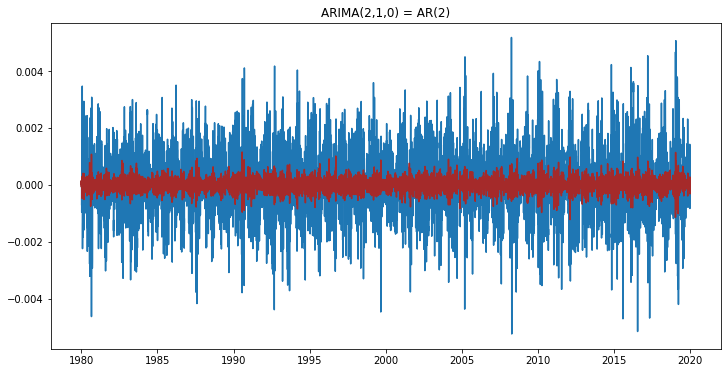

In [ ]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                              ARIMA Model Results                              
Dep. Variable:     D.Concentracion CO2   No. Observations:                14608
Model:                  ARIMA(0, 1, 4)   Log Likelihood               87732.003
Method:                        css-mle   S.D. of innovations              0.001
Date:                 Thu, 25 Feb 2021   AIC                        -175452.005
Time:                         01:10:20   BIC                        -175406.469
Sample:                     01-02-1980   HQIC                       -175436.877
                          - 12-30-2019                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      5.973e-06   2.05e-06      2.908      0.004    1.95e-06       1e-05
ma.L1.D.Concentracion CO2    -0.3027      0.008    -36.588      0.000      -0.

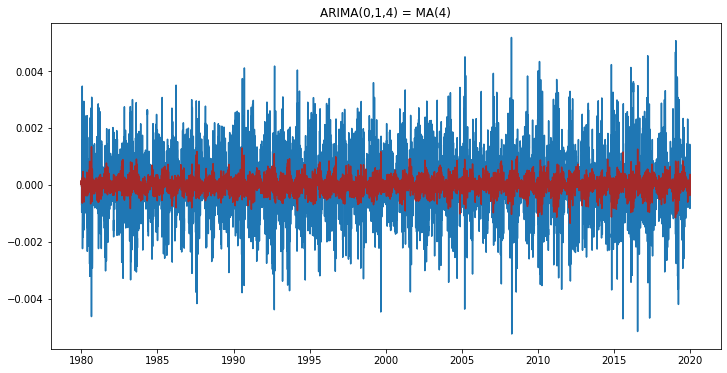

In [ ]:
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_test_log, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


                              ARIMA Model Results                              
Dep. Variable:     D.Concentracion CO2   No. Observations:                14608
Model:                  ARIMA(2, 1, 4)   Log Likelihood               87721.353
Method:                        css-mle   S.D. of innovations              0.001
Date:                 Thu, 25 Feb 2021   AIC                        -175426.707
Time:                         01:11:18   BIC                        -175365.992
Sample:                     01-02-1980   HQIC                       -175406.536
                          - 12-30-2019                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      5.974e-06   2.04e-06      2.922      0.003    1.97e-06    9.98e-06
ar.L1.D.Concentracion CO2     0.3781        nan        nan        nan         

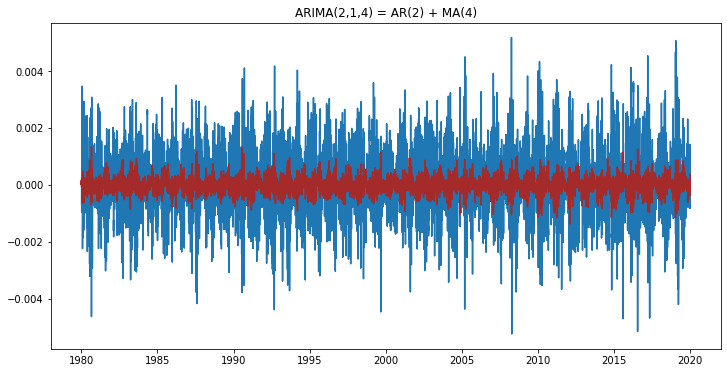

In [ ]:
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_test_log, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

Según la AIC el mejor modelo en este caso es el modelo ARIMA, porque es el modelo con el valor mínimo de AIC

##   Contrasta la serie observada de concentraciones de CO2 contra la construida por el modelo ARIMA.

In [ ]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Fecha
1980-01-02    0.000006
1980-01-03    0.000148
1980-01-04    0.000007
1980-01-05   -0.000003
1980-01-06    0.000013
                ...   
2019-12-26    0.000386
2019-12-27   -0.000079
2019-12-28   -0.000206
2019-12-29   -0.000023
2019-12-30   -0.000163
Length: 14608, dtype: float64


In [ ]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log = pd.Series(ts_test_log, index = ts_test_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())

Fecha
1980-01-01         NaN
1980-01-02    2.528048
1980-01-03    2.528744
1980-01-04    2.528538
1980-01-05    2.528464
dtype: float64
Fecha
2019-12-26    2.615905
2019-12-27    2.615714
2019-12-28    2.615050
2019-12-29    2.615906
2019-12-30    2.616103
dtype: float64


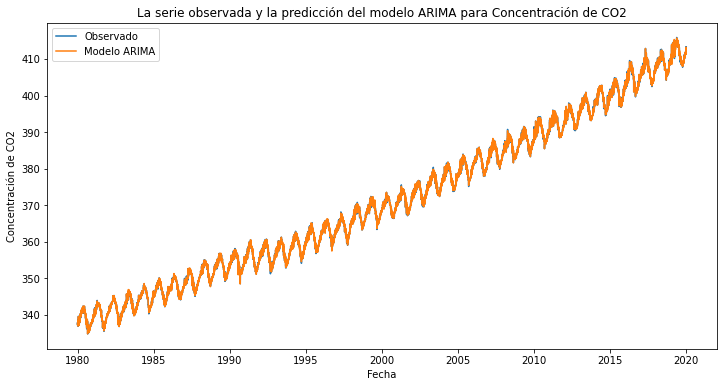

In [ ]:
# Regresamos a la escala original 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Concentración de CO2')
plt.title('La serie observada y la predicción del modelo ARIMA para Concentración de CO2')
plt.legend(loc='best');

##  Calcula el error RMSE

In [ ]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test)**2))
print('RMSE:', RMSE)

RMSE: 0.1884671801530273


## Por último contrasta los 5 últimos años de la Serie de CO2 y el modelo ARIMA para ver mas a detalles el modelo.

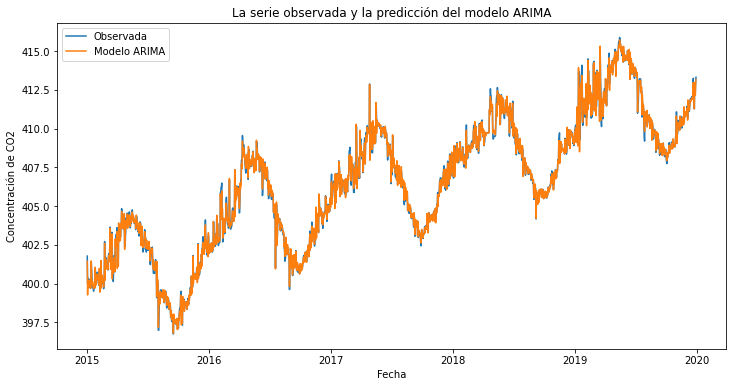

In [ ]:
# Graficamos sólo los útimos datos de las series 
ts_test_last = ts_test.tail(1825)
predictions_ARIMA_last = predictions_ARIMA.tail(1825)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Concentración de CO2')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');